# **AI PROJECT CONTINUATION (PART 2)**
## BY: ALI VIJDAAN
## REG: 20222560

### **The following code has been solely coded by me plus a little of gpt**

**Importing Libraries**

In [ ]:
import numpy as np
import pandas as pd
import glob
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import matplotlib.colors as mcolors
import cv2
from PIL import Image
from sklearn.preprocessing import MinMaxScaler

### **PIPELINE**

###Upload Image --> Mask Detection Through CNN --> Find Antecedants of Image --> Apply Fuzzy Logic

Masks Detection Through CNN has been completed in Part 1

In [ ]:
#data paths
images_data_path = '/content/drive/MyDrive/Colab Notebooks/CNN AI Project/images'
annotations_path = '/content/drive/MyDrive/Colab Notebooks/CNN AI Project/annotations'

Parsing xml file

In [ ]:
#Parsing annotation object
def parse_annotation_object(annotation_object):
    params = {}
    for param in list(annotation_object):
        if param.tag == 'name':
            params['name'] = param.text
        if param.tag == 'bndbox':
            for coord in list(param):
                params[coord.tag] = int(coord.text)
    return params

In [ ]:
#Extracting information from XML file and creating DataFrame
dataset = []
for anno in glob.glob(annotations_path + "/*.xml"):
    tree = ET.parse(anno)
    root = tree.getroot()
    constants = {'file': root.find('filename').text[0:-4]}
    objects = root.findall('object')
    for obj in objects:
        object_params = parse_annotation_object(obj)
        dataset.append({**constants, **object_params})

df = pd.DataFrame(dataset)

In [ ]:
df.head(10)

,file,name,xmin,ymin,xmax,ymax
0,maksssksksss0,without_mask,79,105,109,142
1,maksssksksss0,with_mask,185,100,226,144
2,maksssksksss0,without_mask,325,90,360,141
3,maksssksksss10,with_mask,98,267,194,383
4,maksssksksss100,with_mask,189,30,245,88
5,maksssksksss100,with_mask,387,54,400,75
6,maksssksksss100,with_mask,118,87,163,126
7,maksssksksss1,with_mask,321,34,354,69
8,maksssksksss1,with_mask,224,38,261,73
9,maksssksksss1,with_mask,299,58,315,81


In [ ]:
df['name'].value_counts()

name
with_mask                3232
without_mask              717
mask_weared_incorrect     123
Name: count, dtype: int64

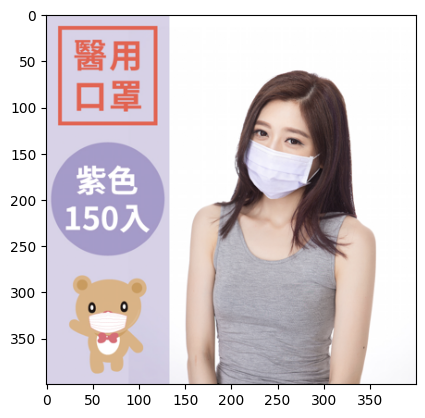

In [ ]:
#display images
img = mpimg.imread("/content/drive/MyDrive/Colab Notebooks/CNN AI Project/images/maksssksksss224.png")
imgplot = plt.imshow(img)
plt.show()

# Plotting Bounding Box


maksssksksss137


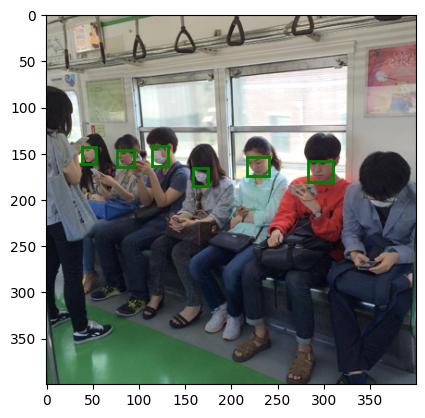

In [ ]:
#Plot Bounding Boxes Through Dataset

# Load the image
image_path = r'/content/drive/MyDrive/Colab Notebooks/CNN AI Project/images/maksssksksss137.png'
img = plt.imread(image_path)
image_name = image_path.replace(r'/content/drive/MyDrive/Colab Notebooks/CNN AI Project/images/', '').replace('.png', '')
print(image_name)

specific_image_df = df[df['file'] == image_name]
# Iterate through the dataset rows
for index, row in specific_image_df.iterrows():
	# Extract coordinates
	xmin, xmax, ymin, ymax = row['xmin'], row['xmax'], row['ymin'], row['ymax']

	# Draw bounding box
	rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2, edgecolor='g', facecolor='none')
	plt.gca().add_patch(rect)

# Display the image with bounding boxes
plt.imshow(img)
plt.show()

Getting Bounding Box Size

In [ ]:
def get_box_size(df):
    df['x-midpoint'] = ((df['xmin'] + df['xmax'])/ 2)
    df['y-midpoint'] = ((df['ymin'] + df['ymax'])/ 2)
    df['bounding box size'] = (df['xmax'] - df['xmin']) * (df['ymax'] - df['ymin'])

    return df

In [ ]:
specific_image_df = get_box_size(specific_image_df)

<ipython-input-293-b99d42bc70a8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['x-midpoint'] = ((df['xmin'] + df['xmax'])/ 2)
<ipython-input-293-b99d42bc70a8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['y-midpoint'] = ((df['ymin'] + df['ymax'])/ 2)
<ipython-input-293-b99d42bc70a8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

In [ ]:
specific_image_df

,file,name,xmin,ymin,xmax,ymax,x-midpoint,y-midpoint,bounding box size
125,maksssksksss137,without_mask,38,143,53,161,45.5,152.0,270
126,maksssksksss137,without_mask,76,146,95,164,85.5,155.0,342
127,maksssksksss137,with_mask,114,142,131,163,122.5,152.5,357
128,maksssksksss137,with_mask,158,165,175,185,166.5,175.0,340
129,maksssksksss137,without_mask,217,153,241,174,229.0,163.5,504
130,maksssksksss137,without_mask,283,158,310,181,296.5,169.5,621


Getting Distance Between Bounding Boxes

In [ ]:
def euclidian_distance(row1, row2):
    return np.sqrt((row1['x-midpoint'] - row2['x-midpoint'])**2 + (row1['y-midpoint'] - row2['y-midpoint'])**2)

distances = []

def get_distances(df):
    distances = []
    for i in range(len(df)):
        min_dist = float('inf')
        for j in range(len(df)):
            if i == j:
                continue
            distance = euclidian_distance(df.iloc[i], df.iloc[j])
            min_dist = min(min_dist, distance)

        distances.append(min_dist)

    df['distance'] = distances

In [ ]:
get_distances(specific_image_df)

<ipython-input-296-05ec4ecb81da>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance'] = distances


In [ ]:
specific_image_df

,file,name,xmin,ymin,xmax,ymax,x-midpoint,y-midpoint,bounding box size,distance
125,maksssksksss137,without_mask,38,143,53,161,45.5,152.0,270,40.112342
126,maksssksksss137,without_mask,76,146,95,164,85.5,155.0,342,37.084363
127,maksssksksss137,with_mask,114,142,131,163,122.5,152.5,357,37.084363
128,maksssksksss137,with_mask,158,165,175,185,166.5,175.0,340,49.419126
129,maksssksksss137,without_mask,217,153,241,174,229.0,163.5,504,63.549194
130,maksssksksss137,without_mask,283,158,310,181,296.5,169.5,621,67.766142


Finding Density of bounding boxes in each grid

In [ ]:
def localized_bounding_box_density(df):
    image_size = (400, 400)
    grid_size = (100, 100)

    num_grids_x = image_size[0] // grid_size[0]
    num_grids_y = image_size[1] // grid_size[1]

    grids = np.zeros((num_grids_x, num_grids_y, 2), dtype=int)

    for i in range(num_grids_x):
        for j in range(num_grids_y):
            grids[i, j, 0] = i * grid_size[0]
            grids[i, j, 1] = j * grid_size[1]

    # Initialize an array to store the count of bounding boxes in each grid
    grid_counts = np.zeros((4,4))

    # Loop through each grid
    for i in range(4):
            for j in range(4):
		        # Get the top-left coordinates of the current grid
                grid_x, grid_y = grids[i, j, 0], grids[i, j, 1]
                # Filter the dataframe to get bounding boxes that overlap with the current grid
                overlapping_boxes = df[(df['xmin'] < grid_x + 100) & (df['xmax'] > grid_x) & (df['ymin'] < grid_y + 100) & (df['ymax'] > grid_y)]
		        # Count the number of overlapping bounding boxes
                grid_counts[i, j] = len(overlapping_boxes)

    return grid_counts

# Now, 'grid_counts' contains the count of bounding boxes in each grid


In [ ]:
grid_counts = localized_bounding_box_density(specific_image_df)

In [ ]:
grid_counts = np.flipud(grid_counts)
grid_counts = np.rot90(grid_counts, -1)
print(grid_counts)

[[0. 0. 0. 0.]
 [2. 2. 2. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [ ]:
grid_counts.shape
grid_counts[1, 1]

2.0

TypeError: Rectangle.__init__() missing 1 required positional argument: 'height'

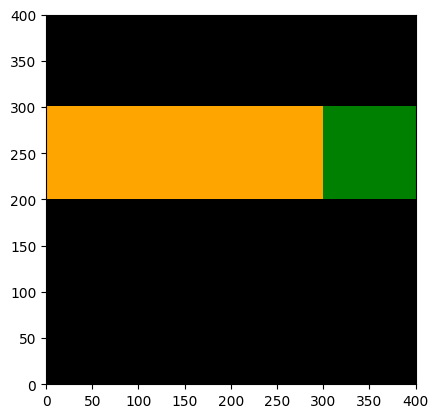

In [ ]:
import matplotlib.pyplot as plt

cmap = mcolors.ListedColormap(['black', 'green', 'orange', 'red'])

# Plot the grid cells
plt.imshow(grid_counts, cmap=cmap, vmin=0, vmax=3, interpolation='nearest', extent=[0, 400, 0, 400])

# Plot the bounding boxes
for index, row in df.iterrows():
	plt.gca().add_patch(Rectangle((row['xmin'], row['ymin']), (row['xmax'] - row['xmin'], row['ymax'] - row['ymin']), fill=False))

plt.show()

#######
# The cell runs fine but due to matplotlib library Rectangle requiring
# another arguement it shows as an error. Please overlook this error
#######

# Implementing Fuzzy Logic

In [ ]:
pip install scikit-fuzzy

In [ ]:
import skfuzzy as fuzz
from skfuzzy import control as ctrl

*ANTECEDENTS*
1. Distance  (distance between people/maximum possible distance)
2. Bounding Box Size (bounding box size / maximum possible size)
3. Local Bounding Box Density (number of boxes / image area)

*RULES FOR DEGREE OF SOCIAL DISTANCING*
1. Severe : 0 | 0 - 0.3
2. Moderate : 0.5 | 0.3 - 0.7
3. Safe : 1 | 0.7 - 1

In [ ]:
distance = ctrl.Antecedent(np.arange(0, 410, 10), 'distance')
bounding_box_size = ctrl.Antecedent(np.arange(0, 50000, 1000), 'box_size')
local_box_density = ctrl.Antecedent(np.arange(0, 5, 1), 'box_density')
sop_severity = ctrl.Consequent(np.arange(0, 1.1, 0.1), 'sop_severity')

In [ ]:
distance['close'] = fuzz.trimf(distance.universe, [0, 0, 50])
distance['moderate'] = fuzz.trimf(distance.universe, [0, 50, 150])
distance['far'] = fuzz.trimf(distance.universe, [150, 400, 400])
bounding_box_size['small'] = fuzz.trimf(bounding_box_size.universe, [0, 0, 1500])
bounding_box_size['average'] = fuzz.trimf(bounding_box_size.universe, [0, 1500, 7000])
bounding_box_size['large'] = fuzz.trimf(bounding_box_size.universe, [7000, 50000, 50000])
local_box_density['low'] = fuzz.trimf(local_box_density.universe, [0, 0, 2])
local_box_density['medium'] = fuzz.trimf(local_box_density.universe, [0, 2, 4])
local_box_density['high'] = fuzz.trimf(local_box_density.universe, [2, 4, 4])
sop_severity['severe'] = fuzz.trimf(sop_severity.universe, [0, 0, 0.6])
sop_severity['moderate'] = fuzz.trimf(sop_severity.universe, [0.2, 0.5, 0.8])
sop_severity['safe'] = fuzz.trimf(sop_severity.universe, [0.6, 1, 1])

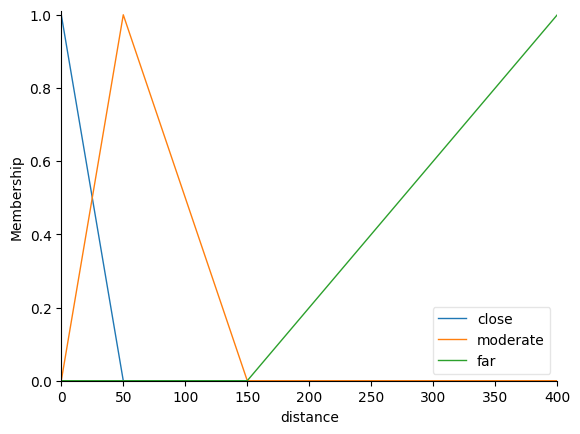

In [ ]:
distance.view()

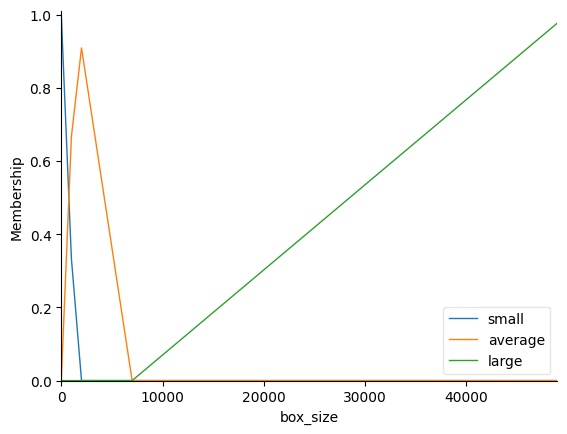

In [ ]:
bounding_box_size.view()

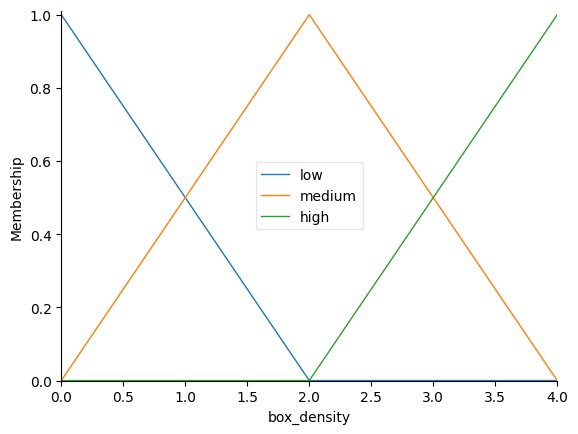

In [ ]:
local_box_density.view()

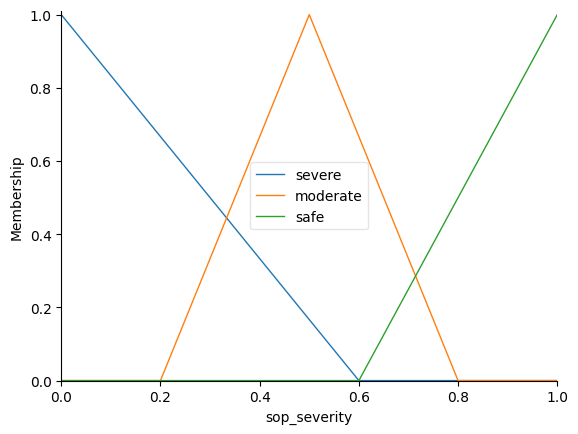

In [ ]:
sop_severity.view()

ANTECEDENTS: Distance, Box Size, Box Density

RULE 1: If:
            Distance = poor
            Box Size = large
            Box Density = high
        Then:
            SOP = severe

RULE 2: If:
            Distance = average
            Box Size = average
            Box Density = medium
        Then:
            SOP = moderate

RULE 3: If:
            Distance = good
            Box Size = safe
            Box Density = low
        Then:
            SOP = safe


### Normalization of Antecedants

## Setting Rules

In [ ]:
rule1 = ctrl.Rule(distance['close'] & bounding_box_size['large'] & local_box_density['high'], sop_severity['severe'])
rule2 = ctrl.Rule(distance['close'] & bounding_box_size['large'] & local_box_density['medium'], sop_severity['severe'])
rule3 = ctrl.Rule(distance['close'] & bounding_box_size['large'] & local_box_density['low'], sop_severity['moderate'])
rule4 = ctrl.Rule(distance['close'] & bounding_box_size['average'] & local_box_density['high'], sop_severity['severe'])
rule5 = ctrl.Rule(distance['close'] & bounding_box_size['average'] & local_box_density['medium'], sop_severity['severe'])
rule6 = ctrl.Rule(distance['close'] & bounding_box_size['average'] & local_box_density['low'], sop_severity['severe'])
rule7 = ctrl.Rule(distance['close'] & bounding_box_size['small'] & local_box_density['high'], sop_severity['severe'])
rule8 = ctrl.Rule(distance['close'] & bounding_box_size['small'] & local_box_density['medium'], sop_severity['severe'])
rule9 = ctrl.Rule(distance['close'] & bounding_box_size['small'] & local_box_density['low'], sop_severity['severe'])
rule10 = ctrl.Rule(distance['moderate'] & bounding_box_size['large'] & local_box_density['high'], sop_severity['severe'])
rule11 = ctrl.Rule(distance['moderate'] & bounding_box_size['large'] & local_box_density['medium'], sop_severity['severe'])
rule12 = ctrl.Rule(distance['moderate'] & bounding_box_size['large'] & local_box_density['low'], sop_severity['moderate'])
rule13 = ctrl.Rule(distance['moderate'] & bounding_box_size['average'] & local_box_density['high'], sop_severity['severe'])
rule14 = ctrl.Rule(distance['moderate'] & bounding_box_size['average'] & local_box_density['medium'], sop_severity['severe'])
rule15 = ctrl.Rule(distance['moderate'] & bounding_box_size['average'] & local_box_density['low'], sop_severity['moderate'])
rule16 = ctrl.Rule(distance['moderate'] & bounding_box_size['small'] & local_box_density['high'], sop_severity['severe'])
rule17 = ctrl.Rule(distance['moderate'] & bounding_box_size['small'] & local_box_density['medium'], sop_severity['moderate'])
rule18 = ctrl.Rule(distance['moderate'] & bounding_box_size['small'] & local_box_density['low'], sop_severity['safe'])
rule19 = ctrl.Rule(distance['far'] & bounding_box_size['large'] & local_box_density['high'], sop_severity['severe'])
rule20 = ctrl.Rule(distance['far'] & bounding_box_size['large'] & local_box_density['medium'], sop_severity['moderate'])
rule21 = ctrl.Rule(distance['far'] & bounding_box_size['large'] & local_box_density['low'], sop_severity['safe'])
rule22 = ctrl.Rule(distance['far'] & bounding_box_size['average'] & local_box_density['high'], sop_severity['severe'])
rule23 = ctrl.Rule(distance['far'] & bounding_box_size['average'] & local_box_density['medium'], sop_severity['safe'])
rule24 = ctrl.Rule(distance['far'] & bounding_box_size['average'] & local_box_density['low'], sop_severity['safe'])
rule25 = ctrl.Rule(distance['far'] & bounding_box_size['small'] & local_box_density['high'], sop_severity['severe'])
rule26 = ctrl.Rule(distance['far'] & bounding_box_size['small'] & local_box_density['medium'], sop_severity['safe'])
rule27 = ctrl.Rule(distance['far'] & bounding_box_size['small'] & local_box_density['low'], sop_severity['safe'])

In [ ]:
# Assuming df is your dataframe and grid_counts is the (4,4) array
specific_image_df['grid_count'] = 0  # Create a new column

for i, row in specific_image_df.iterrows():
    xmax, ymax = row['xmax'], row['ymax']
    grid_x = int(xmax // 100)
    grid_y = int(ymax // 100)
    print(xmax, ymax, grid_x, grid_y)
    specific_image_df['grid_count'][i] = grid_counts[grid_y, grid_x]

print(grid_counts)

53 161 0 1
95 164 0 1
131 163 1 1
175 185 1 1
241 174 2 1
310 181 3 1
[[0. 0. 0. 0.]
 [2. 2. 2. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


<ipython-input-313-826563a43631>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specific_image_df['grid_count'] = 0  # Create a new column
<ipython-input-313-826563a43631>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specific_image_df['grid_count'][i] = grid_counts[grid_y, grid_x]
<ipython-input-313-826563a43631>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  specific_ima

In [ ]:
specific_image_df

,file,name,xmin,ymin,xmax,ymax,x-midpoint,y-midpoint,bounding box size,distance,grid_count
125,maksssksksss137,without_mask,38,143,53,161,45.5,152.0,270,40.112342,2
126,maksssksksss137,without_mask,76,146,95,164,85.5,155.0,342,37.084363,2
127,maksssksksss137,with_mask,114,142,131,163,122.5,152.5,357,37.084363,2
128,maksssksksss137,with_mask,158,165,175,185,166.5,175.0,340,49.419126,2
129,maksssksksss137,without_mask,217,153,241,174,229.0,163.5,504,63.549194,2
130,maksssksksss137,without_mask,283,158,310,181,296.5,169.5,621,67.766142,1


In [ ]:
sop_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9, rule10, rule11, rule12, rule13, rule14, rule15, rule16, rule17, rule18, rule19, rule20, rule21, rule22, rule23, rule24, rule25, rule26, rule27])
sop = ctrl.ControlSystemSimulation(sop_ctrl)

In [ ]:
dist = specific_image_df['distance'].iloc[2]
box_s = specific_image_df['bounding box size'].iloc[2]
box_d = specific_image_df['grid_count'].iloc[2]
print(dist)

37.08436328157732


In [ ]:
sop.input['distance'] = dist
sop.input['box_size'] = box_s
sop.input['box_density'] = box_d

sop.compute()

print(sop.output['sop_severity'])

0.43002916604098235


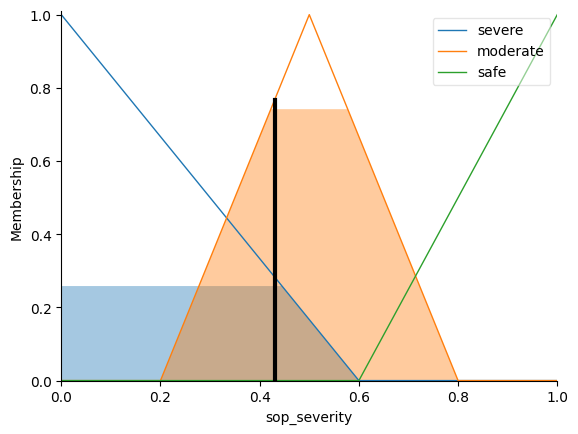

In [ ]:
sop_severity.view(sim=sop)

# **TESTING 1**

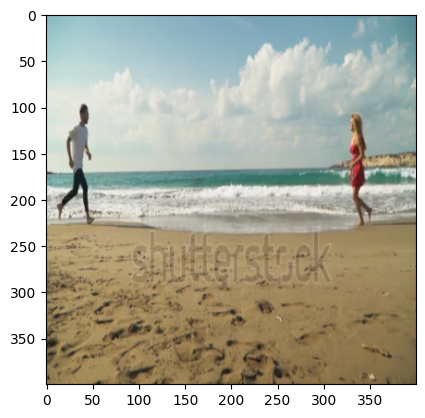

In [ ]:
#display images
img = mpimg.imread("/content/images1.png")
imgplot = plt.imshow(img)
plt.show()

In [ ]:
#Creating DataFrame
d = {"Name" : ["image1", "image1"],
     "xmax" : [49, 347],
     "xmin" : [31, 322],
     "ymax" : [122, 130],
     "ymin" : [95, 105]
}

data = pd.DataFrame(d)
data

,Name,xmax,xmin,ymax,ymin
0,image1,49,31,122,95
1,image1,347,322,130,105


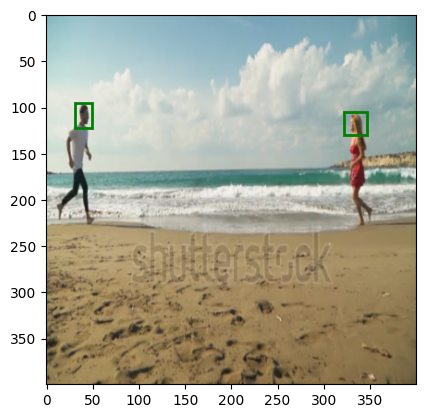

In [ ]:
#Plotting Bounding Box
for index, row in data.iterrows():
	# Extract coordinates
	xmin, xmax, ymin, ymax = row['xmin'], row['xmax'], row['ymin'], row['ymax']

	# Draw bounding box
	rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2, edgecolor='g', facecolor='none')
	plt.gca().add_patch(rect)

# Display the image with bounding boxes
plt.imshow(img)
plt.show()

In [ ]:
#get box size
get_box_size(data)
data

,Name,xmax,xmin,ymax,ymin,x-midpoint,y-midpoint,bounding box size
0,image1,49,31,122,95,40.0,108.5,486
1,image1,347,322,130,105,334.5,117.5,625


In [ ]:
#get distances
get_distances(data)
data

,Name,xmax,xmin,ymax,ymin,x-midpoint,y-midpoint,bounding box size,distance
0,image1,49,31,122,95,40.0,108.5,486,294.637489
1,image1,347,322,130,105,334.5,117.5,625,294.637489


In [ ]:
#get grid counts
bbox_nums = localized_bounding_box_density(data)

In [ ]:
data

,Name,xmax,xmin,ymax,ymin,x-midpoint,y-midpoint,bounding box size,distance
0,image1,49,31,122,95,40.0,108.5,486,294.637489
1,image1,347,322,130,105,334.5,117.5,625,294.637489


In [ ]:
bbox_nums = np.flipud(bbox_nums)
bbox_nums = np.rot90(bbox_nums, -1)
print(bbox_nums)

[[1. 0. 0. 0.]
 [1. 0. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


TypeError: Rectangle.__init__() missing 1 required positional argument: 'height'

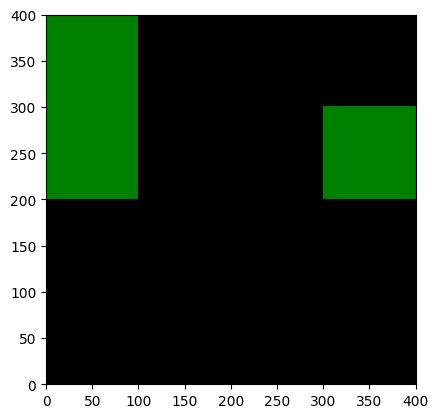

In [ ]:
# Plot the grid cells
plt.imshow(bbox_nums, cmap=cmap, vmin=0, vmax=3, interpolation='nearest', extent=[0, 400, 0, 400])

# Plot the bounding boxes
for index, row in data.iterrows():
	plt.gca().add_patch(Rectangle((row['xmin'], row['ymin']), (row['xmax'] - row['xmin'], row['ymax'] - row['ymin']), fill=False))

plt.show()

In [ ]:
# Assuming df is your dataframe and grid_counts is the (4,4) array
data['grid_count'] = 0  # Create a new column

for i, row in data.iterrows():
    xmax, ymax = row['xmax'], row['ymax']
    grid_x = int(xmax // 100)
    grid_y = int(ymax // 100)
    print(xmax, ymax, grid_x, grid_y)
    data['grid_count'][i] = bbox_nums[grid_y, grid_x]

print(bbox_nums)

49 122 0 1
347 130 3 1
[[1. 0. 0. 0.]
 [1. 0. 0. 1.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


<ipython-input-328-c5d9ff0e95d8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['grid_count'][i] = bbox_nums[grid_y, grid_x]
<ipython-input-328-c5d9ff0e95d8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['grid_count'][i] = bbox_nums[grid_y, grid_x]


In [ ]:
data

,Name,xmax,xmin,ymax,ymin,x-midpoint,y-midpoint,bounding box size,distance,grid_count
0,image1,49,31,122,95,40.0,108.5,486,294.637489,1
1,image1,347,322,130,105,334.5,117.5,625,294.637489,1


In [ ]:
dist = data['distance'].iloc[1]
box_s = data['bounding box size'].iloc[1]
box_d = data['grid_count'].iloc[1]
print(dist)

294.63748912859


In [ ]:
sop.input['distance'] = dist
sop.input['box_size'] = box_s
sop.input['box_density'] = box_d

sop.compute()

print(sop.output['sop_severity'])

0.8444444444444444


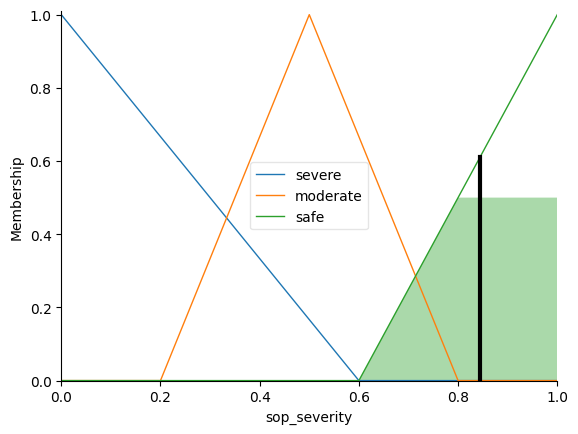

In [ ]:
sop_severity.view(sim=sop)

# **TESTING 2**

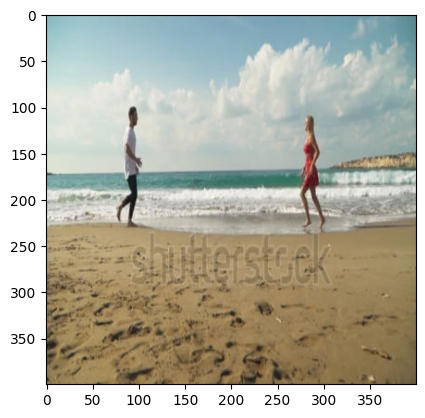

In [ ]:
#display images
img = mpimg.imread("/content/image2.jpg")
imgplot = plt.imshow(img)
plt.show()

In [ ]:
#Creating DataFrame
d = {"Name" : ["image1", "image1"],
     "xmax" : [101, 297],
     "xmin" : [83, 275],
     "ymax" : [125, 128],
     "ymin" : [100, 110]
}

data = pd.DataFrame(d)
data

,Name,xmax,xmin,ymax,ymin
0,image1,101,83,125,100
1,image1,297,275,128,110


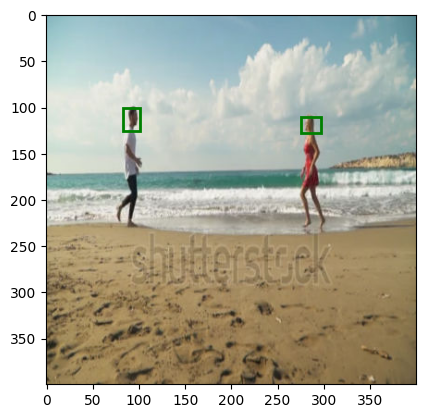

In [ ]:
#Plotting Bounding Box
for index, row in data.iterrows():
	# Extract coordinates
	xmin, xmax, ymin, ymax = row['xmin'], row['xmax'], row['ymin'], row['ymax']

	# Draw bounding box
	rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2, edgecolor='g', facecolor='none')
	plt.gca().add_patch(rect)

# Display the image with bounding boxes
plt.imshow(img)
plt.show()

In [ ]:
#get box size
get_box_size(data)
data

,Name,xmax,xmin,ymax,ymin,x-midpoint,y-midpoint,bounding box size
0,image1,101,83,125,100,92.0,112.5,450
1,image1,297,275,128,110,286.0,119.0,396


In [ ]:
#get distances
get_distances(data)
data

,Name,xmax,xmin,ymax,ymin,x-midpoint,y-midpoint,bounding box size,distance
0,image1,101,83,125,100,92.0,112.5,450,194.108861
1,image1,297,275,128,110,286.0,119.0,396,194.108861


In [ ]:
#get grid counts
bbox_nums = localized_bounding_box_density(data)
bbox_nums

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.]])

In [ ]:
bbox_nums = np.flipud(bbox_nums)
bbox_nums = np.rot90(bbox_nums, -1)
print(bbox_nums)

[[0. 0. 0. 0.]
 [1. 1. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


TypeError: Rectangle.__init__() missing 1 required positional argument: 'height'

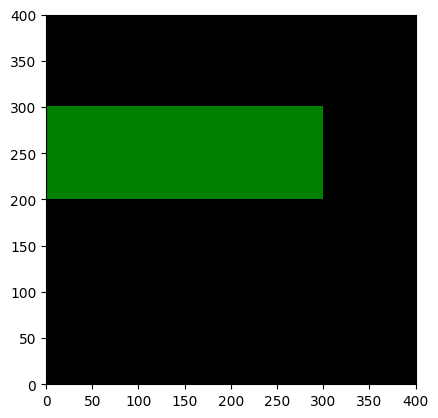

In [ ]:
# Plot the grid cells
plt.imshow(bbox_nums, cmap=cmap, vmin=0, vmax=3, interpolation='nearest', extent=[0, 400, 0, 400])

# Plot the bounding boxes
for index, row in data.iterrows():
	plt.gca().add_patch(Rectangle((row['xmin'], row['ymin']), (row['xmax'] - row['xmin'], row['ymax'] - row['ymin']), fill=False))

plt.show()

In [ ]:
# Assuming df is your dataframe and grid_counts is the (4,4) array
data['grid_count'] = 0  # Create a new column

for i, row in data.iterrows():
    xmax, ymax = row['xmax'], row['ymax']
    grid_x = int(xmax // 100)
    grid_y = int(ymax // 100)
    print(xmax, ymax, grid_x, grid_y)
    data['grid_count'][i] = bbox_nums[grid_y, grid_x]

print(bbox_nums)

101 125 1 1
297 128 2 1
[[0. 0. 0. 0.]
 [1. 1. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


<ipython-input-341-c5d9ff0e95d8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['grid_count'][i] = bbox_nums[grid_y, grid_x]
<ipython-input-341-c5d9ff0e95d8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['grid_count'][i] = bbox_nums[grid_y, grid_x]


In [ ]:
dist = data['distance'].iloc[0]
box_s = data['bounding box size'].iloc[0]
box_d = data['grid_count'].iloc[0]
print(dist)

194.10886120937394


In [ ]:
sop.input['distance'] = dist
sop.input['box_size'] = box_s
sop.input['box_density'] = box_d

sop.compute()

print(sop.output['sop_severity'])

0.8170745221970258


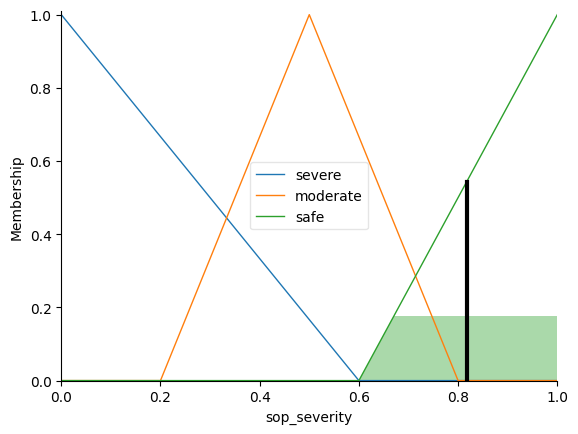

In [ ]:
sop_severity.view(sim=sop)

# **TESTING 3**

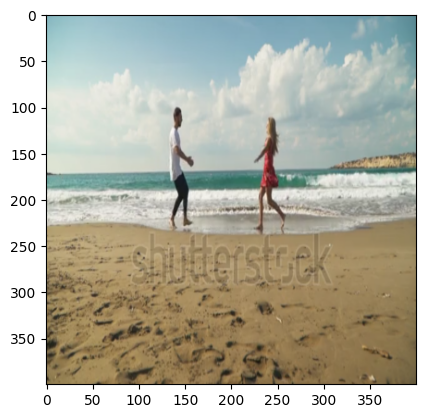

In [ ]:
#display images
img = mpimg.imread("/content/image3.png")
imgplot = plt.imshow(img)
plt.show()

In [ ]:
#Creating DataFrame
d = {"Name" : ["image1", "image1"],
     "xmax" : [152, 253],
     "xmin" : [135, 230],
     "ymax" : [125, 130],
     "ymin" : [100, 110]
}

data = pd.DataFrame(d)
data

,Name,xmax,xmin,ymax,ymin
0,image1,152,135,125,100
1,image1,253,230,130,110


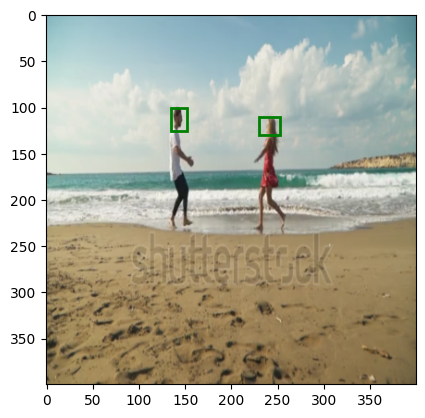

In [ ]:
#Plotting Bounding Box
for index, row in data.iterrows():
	# Extract coordinates
	xmin, xmax, ymin, ymax = row['xmin'], row['xmax'], row['ymin'], row['ymax']

	# Draw bounding box
	rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2, edgecolor='g', facecolor='none')
	plt.gca().add_patch(rect)

# Display the image with bounding boxes
plt.imshow(img)
plt.show()

In [ ]:
#get box size
get_box_size(data)
data

,Name,xmax,xmin,ymax,ymin,x-midpoint,y-midpoint,bounding box size
0,image1,152,135,125,100,143.5,112.5,425
1,image1,253,230,130,110,241.5,120.0,460


In [ ]:
#get distances
get_distances(data)
data

,Name,xmax,xmin,ymax,ymin,x-midpoint,y-midpoint,bounding box size,distance
0,image1,152,135,125,100,143.5,112.5,425,98.286571
1,image1,253,230,130,110,241.5,120.0,460,98.286571


In [ ]:
#get grid counts
bbox_nums = localized_bounding_box_density(data)
bbox_nums

array([[0., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.]])

In [ ]:
bbox_nums = np.flipud(bbox_nums)
bbox_nums = np.rot90(bbox_nums, -1)
print(bbox_nums)

[[0. 0. 0. 0.]
 [0. 1. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


TypeError: Rectangle.__init__() missing 1 required positional argument: 'height'

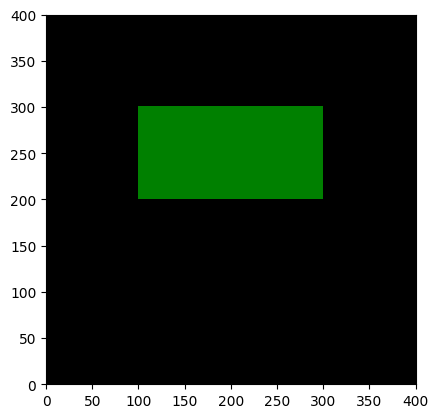

In [ ]:
# Plot the grid cells
plt.imshow(bbox_nums, cmap=cmap, vmin=0, vmax=3, interpolation='nearest', extent=[0, 400, 0, 400])

# Plot the bounding boxes
for index, row in data.iterrows():
	plt.gca().add_patch(Rectangle((row['xmin'], row['ymin']), (row['xmax'] - row['xmin'], row['ymax'] - row['ymin']), fill=False))

plt.show()

In [ ]:
# Assuming df is your dataframe and grid_counts is the (4,4) array
data['grid_count'] = 0  # Create a new column

for i, row in data.iterrows():
    xmax, ymax = row['xmax'], row['ymax']
    grid_x = int(xmax // 100)
    grid_y = int(ymax // 100)
    print(xmax, ymax, grid_x, grid_y)
    data['grid_count'][i] = bbox_nums[grid_y, grid_x]

print(bbox_nums)

152 125 1 1
253 130 2 1
[[0. 0. 0. 0.]
 [0. 1. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


<ipython-input-353-c5d9ff0e95d8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['grid_count'][i] = bbox_nums[grid_y, grid_x]
<ipython-input-353-c5d9ff0e95d8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['grid_count'][i] = bbox_nums[grid_y, grid_x]


In [ ]:
dist = data['distance'].iloc[0]
box_s = data['bounding box size'].iloc[0]
box_d = data['grid_count'].iloc[0]
print(dist)

98.28657080191576


In [ ]:
sop.input['distance'] = dist
sop.input['box_size'] = box_s
sop.input['box_density'] = box_d

sop.compute()

print(sop.output['sop_severity'])

0.548052805280528


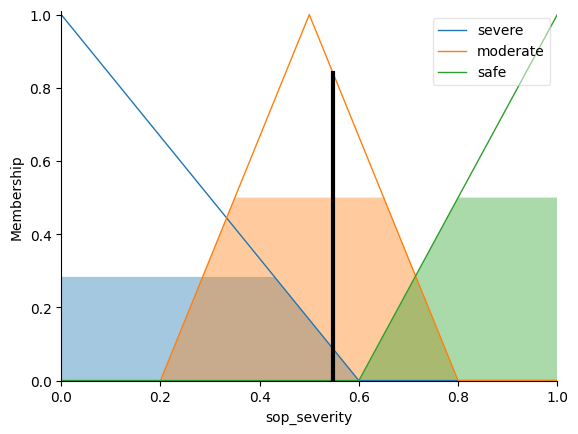

In [ ]:
sop_severity.view(sim=sop)

# **TESTING 4**

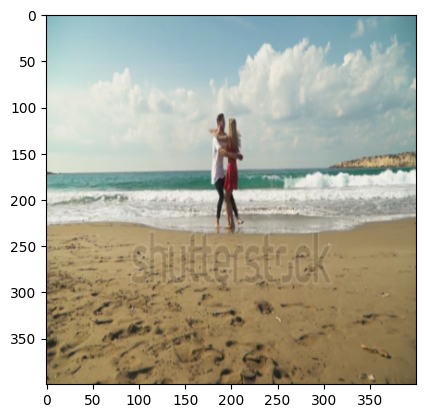

In [ ]:
#display images
img = mpimg.imread("/content/image4.png")
imgplot = plt.imshow(img)
plt.show()

In [ ]:
#Creating DataFrame
d = {"Name" : ["image1", "image1"],
     "xmax" : [194, 211],
     "xmin" : [179, 192],
     "ymax" : [125, 128],
     "ymin" : [100, 110]
}

data = pd.DataFrame(d)
data

,Name,xmax,xmin,ymax,ymin
0,image1,194,179,125,100
1,image1,211,192,128,110


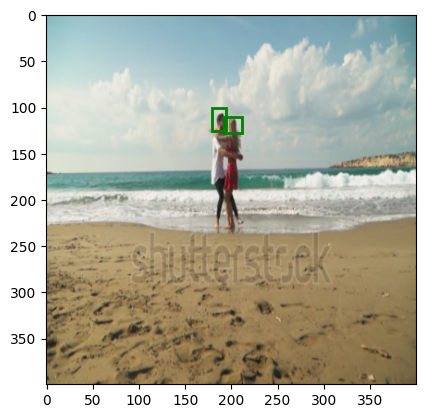

In [ ]:
#Plotting Bounding Box
for index, row in data.iterrows():
	# Extract coordinates
	xmin, xmax, ymin, ymax = row['xmin'], row['xmax'], row['ymin'], row['ymax']

	# Draw bounding box
	rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=2, edgecolor='g', facecolor='none')
	plt.gca().add_patch(rect)

# Display the image with bounding boxes
plt.imshow(img)
plt.show()

In [ ]:
#get box size
get_box_size(data)
data

,Name,xmax,xmin,ymax,ymin,x-midpoint,y-midpoint,bounding box size
0,image1,194,179,125,100,186.5,112.5,375
1,image1,211,192,128,110,201.5,119.0,342


In [ ]:
#get distances
get_distances(data)
data

,Name,xmax,xmin,ymax,ymin,x-midpoint,y-midpoint,bounding box size,distance
0,image1,194,179,125,100,186.5,112.5,375,16.347783
1,image1,211,192,128,110,201.5,119.0,342,16.347783


In [ ]:
#get grid counts
bbox_nums = localized_bounding_box_density(data)
bbox_nums

array([[0., 0., 0., 0.],
       [0., 2., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 0.]])

In [ ]:
bbox_nums = np.flipud(bbox_nums)
bbox_nums = np.rot90(bbox_nums, -1)
print(bbox_nums)

[[0. 0. 0. 0.]
 [0. 2. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


TypeError: Rectangle.__init__() missing 1 required positional argument: 'height'

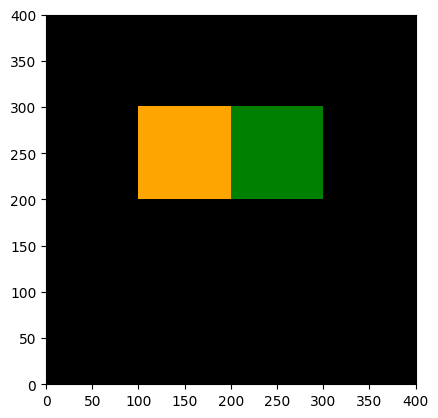

In [ ]:
# Plot the grid cells
plt.imshow(bbox_nums, cmap=cmap, vmin=0, vmax=3, interpolation='nearest', extent=[0, 400, 0, 400])

# Plot the bounding boxes
for index, row in data.iterrows():
	plt.gca().add_patch(Rectangle((row['xmin'], row['ymin']), (row['xmax'] - row['xmin'], row['ymax'] - row['ymin']), fill=False))

plt.show()

In [ ]:
# Assuming df is your dataframe and grid_counts is the (4,4) array
data['grid_count'] = 0  # Create a new column

for i, row in data.iterrows():
    xmax, ymax = row['xmax'], row['ymax']
    grid_x = int(xmax // 100)
    grid_y = int(ymax // 100)
    print(xmax, ymax, grid_x, grid_y)
    data['grid_count'][i] = bbox_nums[grid_y, grid_x]

print(bbox_nums)

194 125 1 1
211 128 2 1
[[0. 0. 0. 0.]
 [0. 2. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


<ipython-input-369-c5d9ff0e95d8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['grid_count'][i] = bbox_nums[grid_y, grid_x]
<ipython-input-369-c5d9ff0e95d8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['grid_count'][i] = bbox_nums[grid_y, grid_x]


In [ ]:
data

,Name,xmax,xmin,ymax,ymin,x-midpoint,y-midpoint,bounding box size,distance,grid_count
0,image1,194,179,125,100,186.5,112.5,375,16.347783,2
1,image1,211,192,128,110,201.5,119.0,342,16.347783,1


In [ ]:
dist = data['distance'].iloc[0]
box_s = data['bounding box size'].iloc[0]
box_d = data['grid_count'].iloc[0]
print(dist)

16.347782724271816


In [ ]:
sop.input['distance'] = dist
sop.input['box_size'] = box_s
sop.input['box_density'] = box_d

sop.compute()

print(sop.output['sop_severity'])

0.31073125460494594


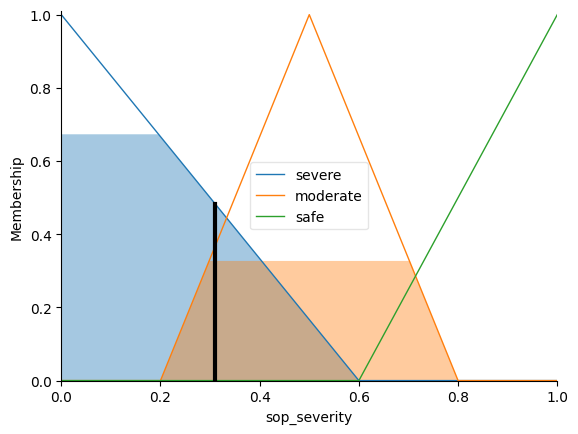

In [ ]:
sop_severity.view(sim=sop)